# Imports 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# 1. Understanding the data 

Looking at the data we can see 2 types of breast cancer being either malignant or benign. furthermore we see 30 features per sample of breast cancer. 

# 2. Load the data

In [2]:
df = pd.read_csv('data/breast-cancer.csv')

In [3]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# 3. Exploratory analysis

In [4]:
# there are no nan 
df.isnull().values.any()

False

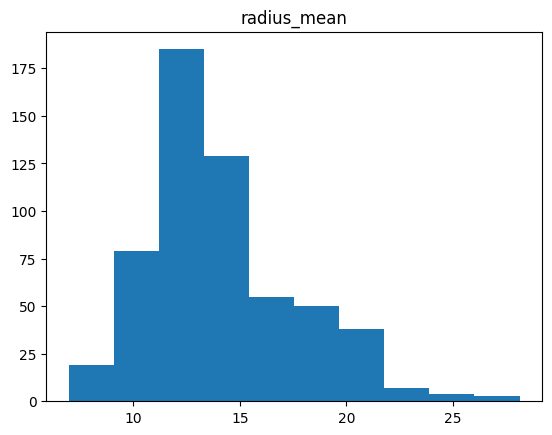

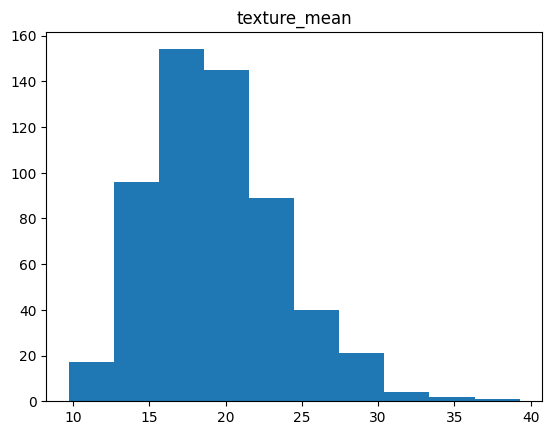

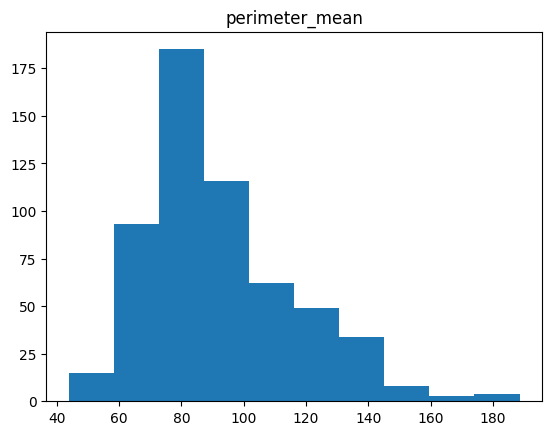

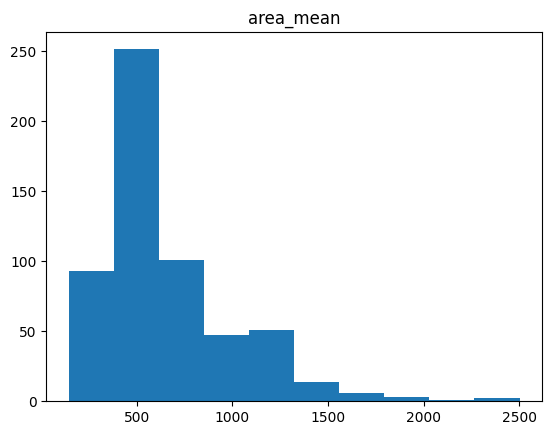

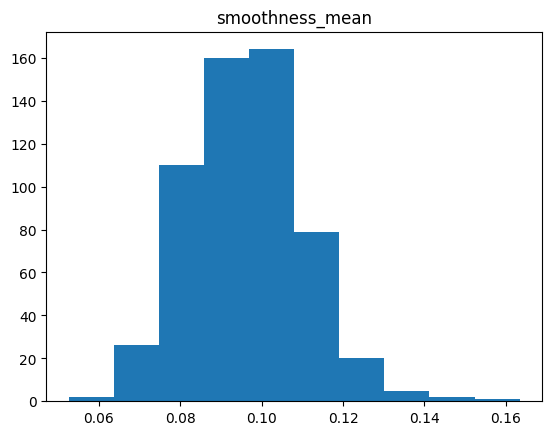

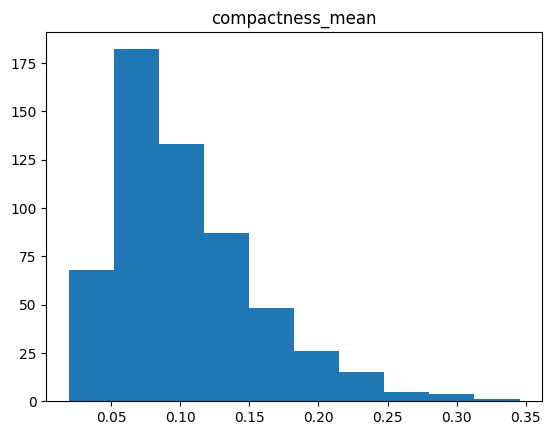

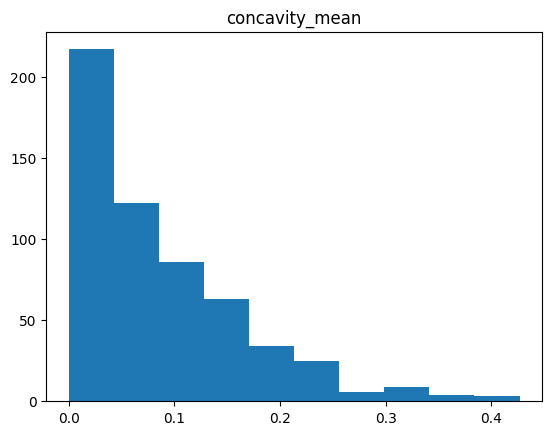

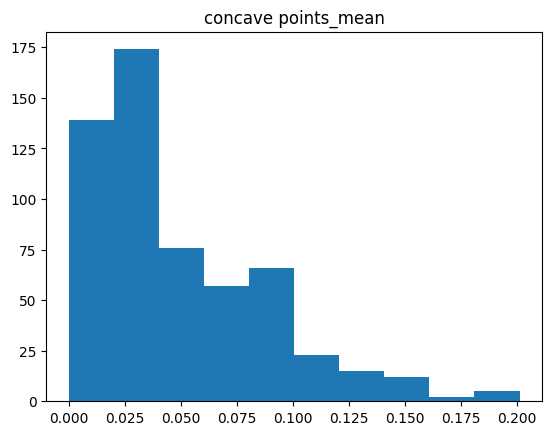

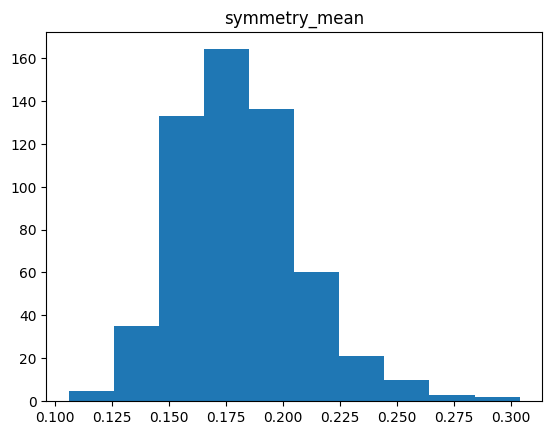

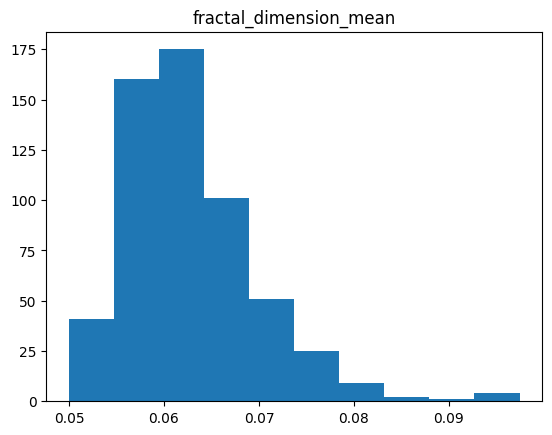

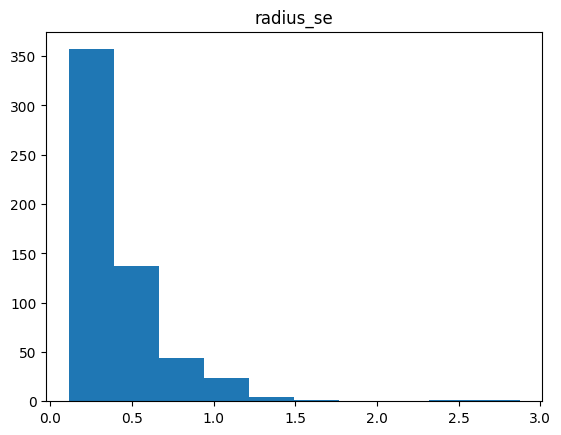

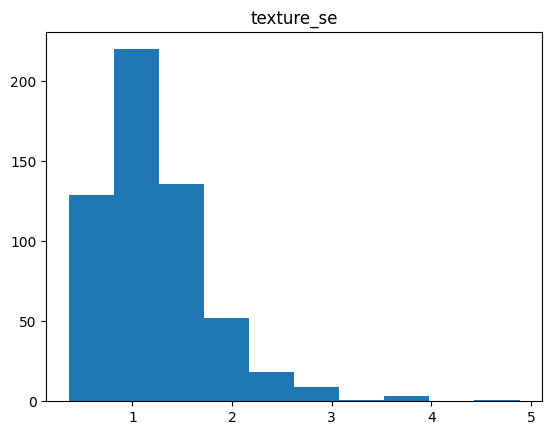

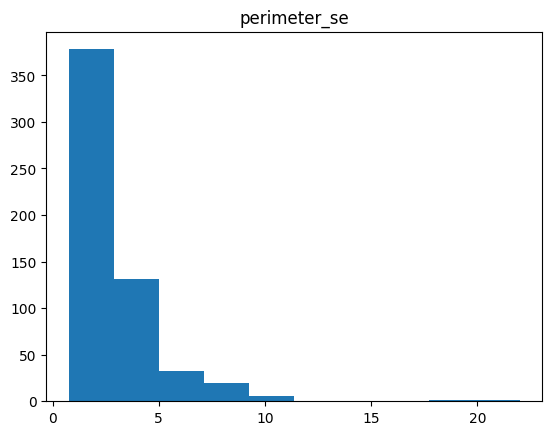

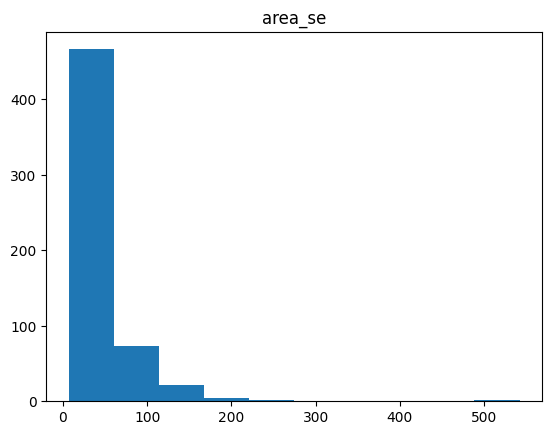

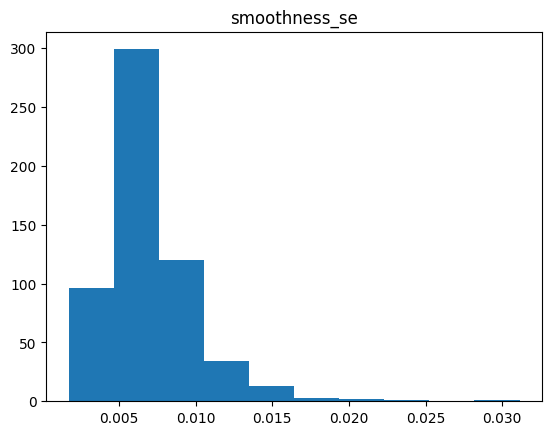

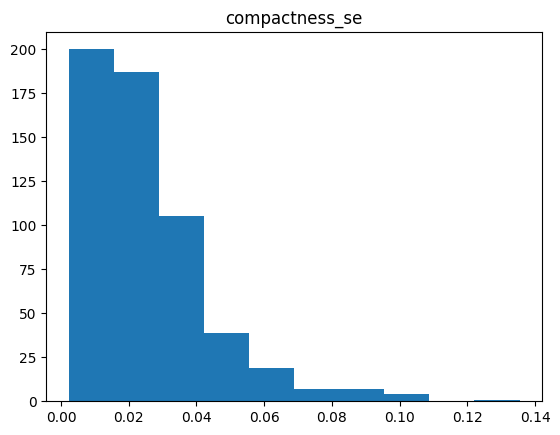

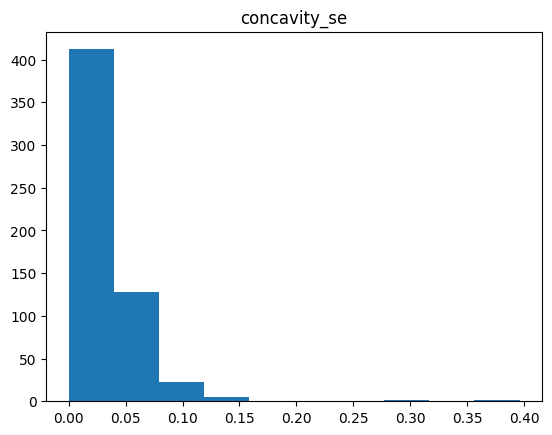

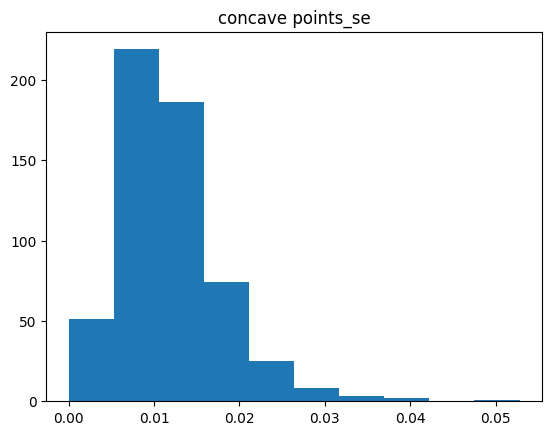

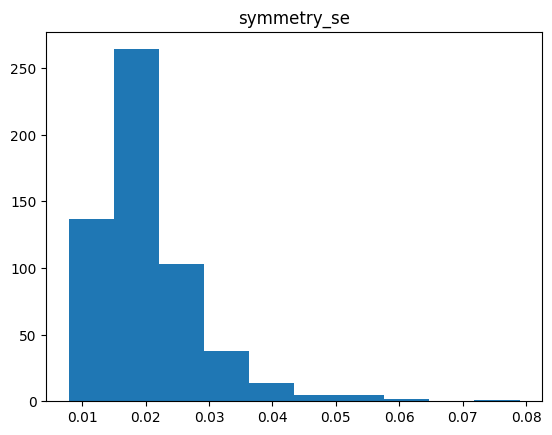

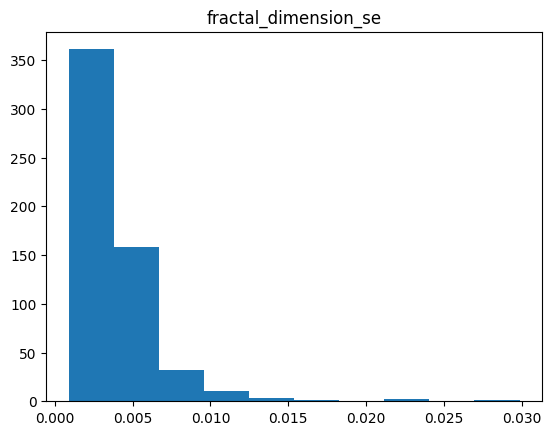

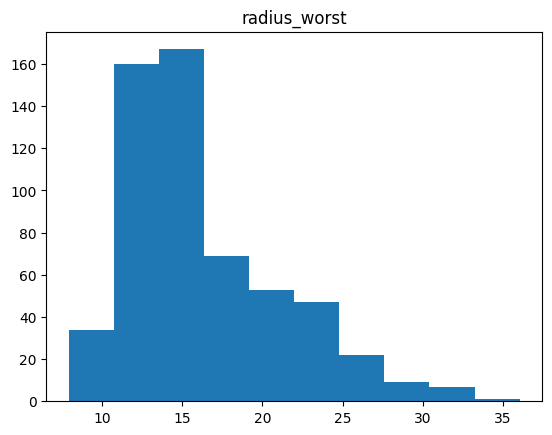

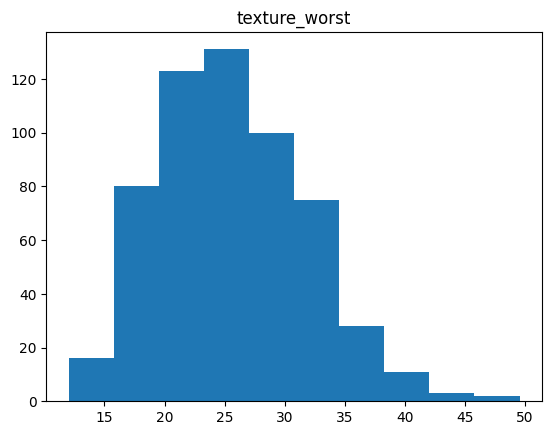

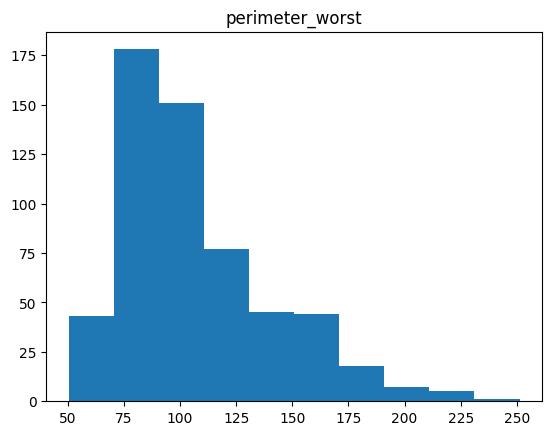

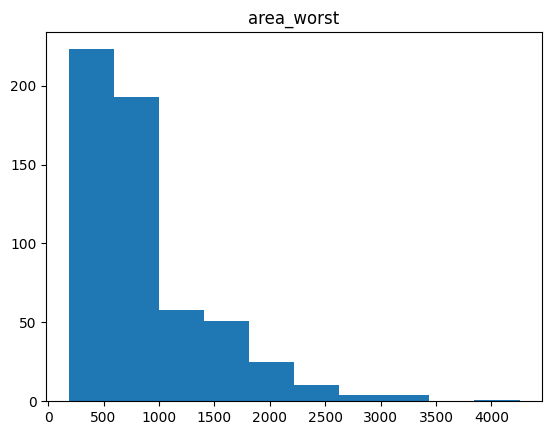

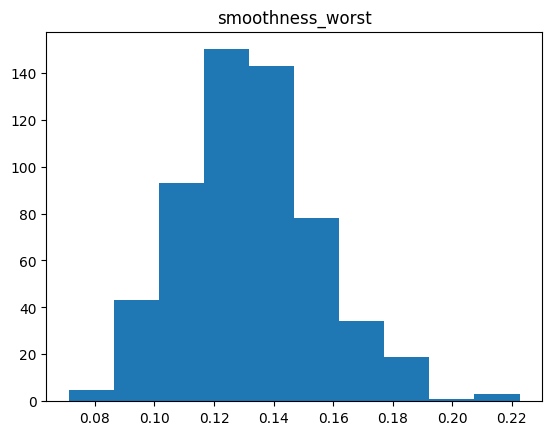

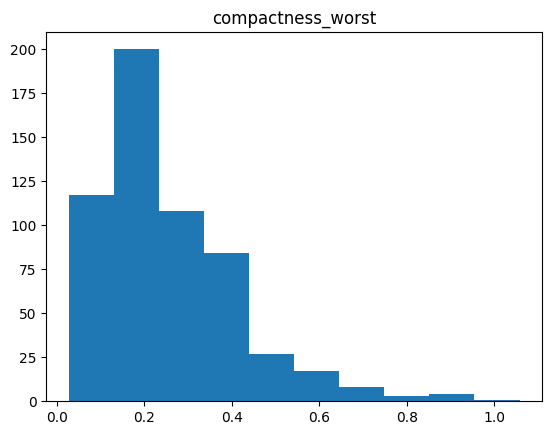

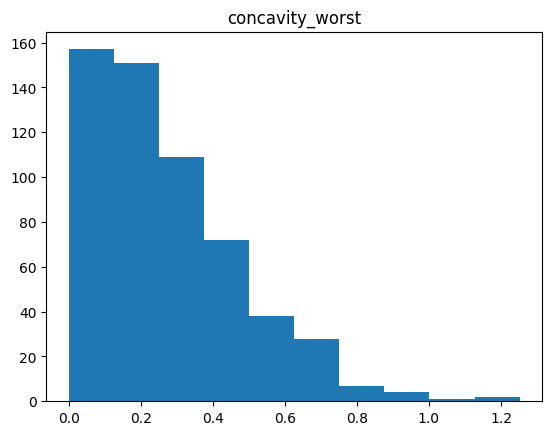

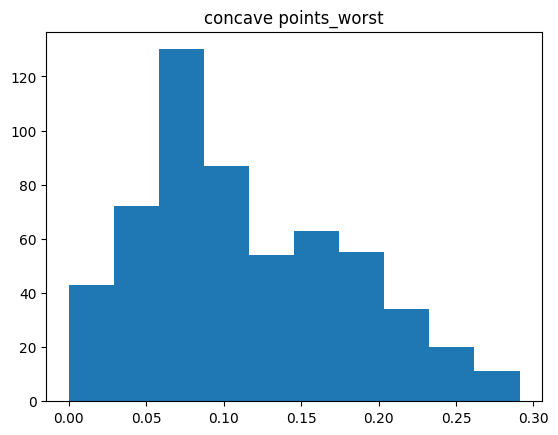

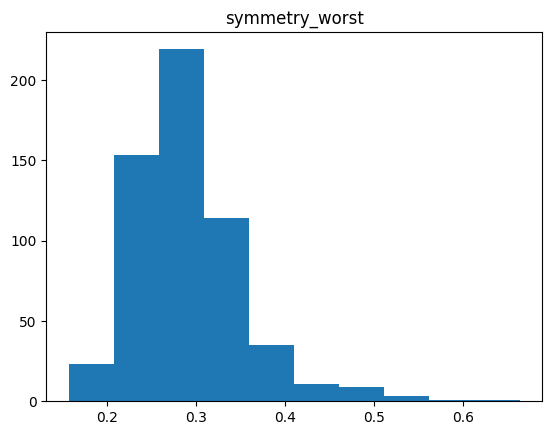

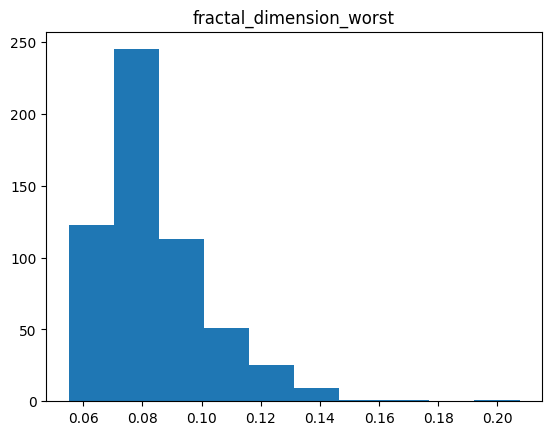

In [5]:
for index, i in enumerate(df.values[:, 2:].T):
    plt.title(df.columns[index+2])
    plt.hist(i)
    plt.show()


## LDA 
To look which components maximizes the separation between malignant and benign we are going to use to train the model

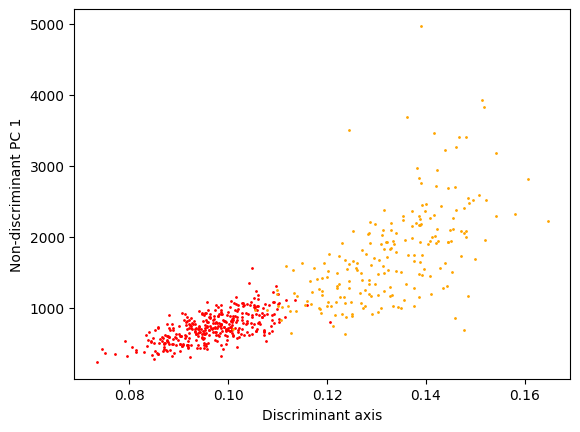

In [6]:
### step 1: devide your data
malignant = np.array(df[df.diagnosis == 'M'].values[:, 2:], dtype=float)
benign = np.array(df[df.diagnosis == 'B'].values[:, 2:], dtype=float)
### step2: calculated the mean and the covariance
mw = malignant.mean(axis=0)
mr = benign.mean(axis=0)

nw = malignant.shape[0]
nr = benign.shape[0]

Sw = np.cov(malignant.T)
Sr = np.cov(benign.T)
### step3: calculated the pooled covariance matrix
Sp = ((nr - 1) * Sr + (nw - 1) * Sw) / (nr + nw - 2)
### step4: project the data onto the discriminant axis
a = np.linalg.inv(Sp) @ (mw - mr)
a /= np.sqrt((a ** 2).sum())

tw = malignant @ a
tr = benign @ a

### step5: deflate both groups, combine and plot the data

Ew = malignant - tw[:, None] * a[None, :]
Er = benign - tr[:, None] * a[None, :]

X = np.concatenate((Ew, Er), axis=0)
S = np.cov(X.T)
vals, vecs = np.linalg.eig(S)
order = vals.argsort()[::-1]
vecs = vecs[:, order]
vals = vals[order]
Tw = malignant @ vecs
Tr = benign @ vecs


plt.scatter(tr, Tr[:, 0], s=1, c="red")
plt.scatter(tw, Tw[:, 0], s=1, c="orange")
plt.xlabel("Discriminant axis")
plt.ylabel("Non-discriminant PC 1")  
plt.show()

In [7]:
separation = [i/sum(vals)*100 for i in vals]
# the first component has 98% of the separation between the two groups
print(separation[:5])
# the first feature is the component that has 98% of the separation
print(order[:5])

[98.20446717546164, 1.6176489875553746, 0.15575107362089868, 0.012093183393653905, 0.008827244953170887]
[0 1 2 3 4]


# 4. Modeling (cross-validation and training)

In [8]:
X = np.array(df.values[:, 2], dtype=float)
X = np.reshape(X, (569,1))
y = df.values[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [10]:
dummy = DummyClassifier(random_state=42)
params = {
    'strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']
}
dummy_grid = GridSearchCV(dummy, params, verbose=1)
best_dummy = dummy_grid.fit(X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/dummy.py", line 196, in fit
    raise ValueError(
ValueError: Constant target value has to be specified when the constant strategy is used.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_

# 5. Evaluation
a confussion matrix helps to see how well the models predict a certain class. In the last confusion matrices below the 0 and 1 on both axis means benign and malignant respectively. 



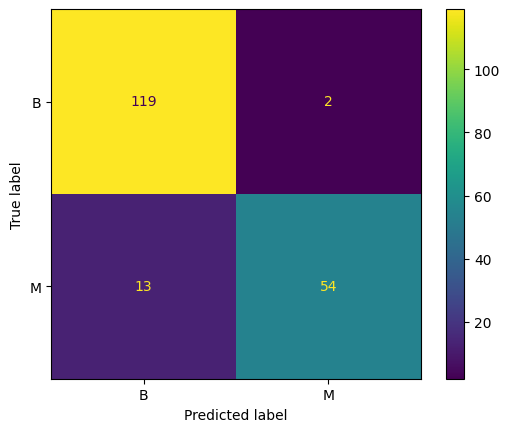

In [11]:
ConfusionMatrixDisplay.from_estimator(ada, X_test, y_test)

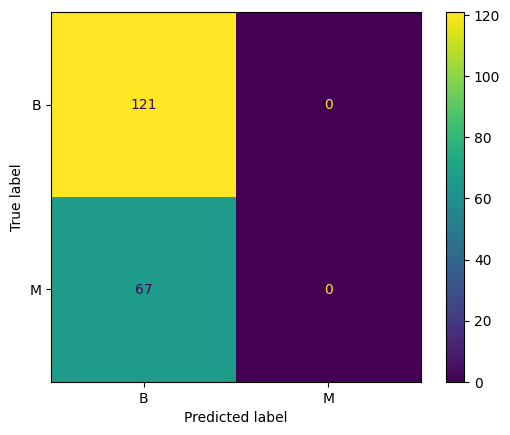

In [12]:
ConfusionMatrixDisplay.from_estimator(best_dummy, X_test, y_test)

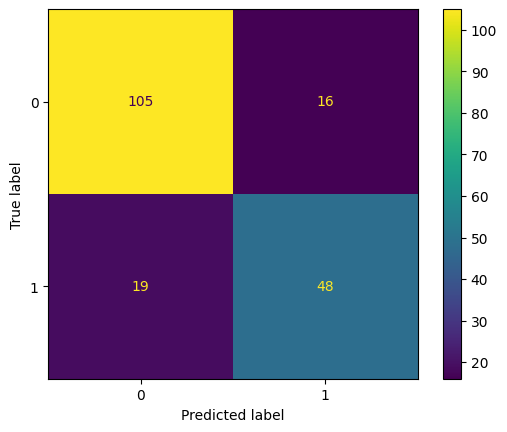

In [13]:
for index, value in enumerate(y):
    if value == 'M':
        y[index] = 1
    if value == 'B':
        y[index] = 0
y = np.array(y, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGBoost = XGBClassifier()
XGBoost.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(XGBoost, X_test, y_test)